<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Прогнозирование-температуры-звезды" data-toc-modified-id="Прогнозирование-температуры-звезды-1">Прогнозирование температуры звезды</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1">Загрузка данных</a></span></li><li><span><a href="#Предобработка-и-анализ-данных" data-toc-modified-id="Предобработка-и-анализ-данных-1.2">Предобработка и анализ данных</a></span><ul class="toc-item"><li><span><a href="#Абсолютная-температура" data-toc-modified-id="Абсолютная-температура-1.2.1">Абсолютная температура</a></span></li><li><span><a href="#Дополнительный-признак" data-toc-modified-id="Дополнительный-признак-1.2.2">Дополнительный признак</a></span></li><li><span><a href="#Относительная-светимость" data-toc-modified-id="Относительная-светимость-1.2.3">Относительная светимость</a></span></li><li><span><a href="#Относительный-радиус" data-toc-modified-id="Относительный-радиус-1.2.4">Относительный радиус</a></span></li><li><span><a href="#Абсолютная-звёздная-величина" data-toc-modified-id="Абсолютная-звёздная-величина-1.2.5">Абсолютная звёздная величина</a></span></li><li><span><a href="#Тип-звезды" data-toc-modified-id="Тип-звезды-1.2.6">Тип звезды</a></span></li><li><span><a href="#Звёздный-цвет" data-toc-modified-id="Звёздный-цвет-1.2.7">Звёздный цвет</a></span></li></ul></li><li><span><a href="#Построение-базовой-нейронной-сети" data-toc-modified-id="Построение-базовой-нейронной-сети-1.3">Построение базовой нейронной сети</a></span></li><li><span><a href="#Улучшение-нейронной-сети" data-toc-modified-id="Улучшение-нейронной-сети-1.4">Улучшение нейронной сети</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.5">Выводы</a></span></li></ul></li></ul></div>

# Прогнозирование температуры звезды

От обсерватории «Небо на ладони» пришла задача: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:  
• Закон смещения Вина.  
• Закон Стефана-Больцмана.  
• Спектральный анализ.  
Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным. Критерием качества нейронной сети выступает метрика `RMSE`, по техническому заданию она не должна превышать 4500.  
В базе обсерватории есть характеристики уже изученных 240 звёзд.

In [1]:
# !pip install scikit-learn==1.1.1
# !pip install matplotlib==3.8.0
# !pip install seaborn==0.13.0
# !pip install optuna
# !pip install phik
# !pip install skorch

## Загрузка данных

In [2]:
import math
import os
import random
import re

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import phik
import seaborn as sns
import torch
import torch.nn as nn
from IPython.display import HTML, display
from scipy.constants import sigma
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (KFold, cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from torch.optim import Adam
from tqdm import tqdm

In [3]:
SEED = 12345

display(HTML('<style>.container { width:90% !important; }</style>'))
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('darkgrid')
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [4]:
def get_df(file_name):
    path_to_file = os.path.relpath(os.path.join('datasets/', file_name))
    if not os.path.isfile(path_to_file):
        raise Exception('Данные отсутствуют')
    return pd.read_csv(path_to_file)

In [5]:
df = get_df('6_class.csv')

In [6]:
df.info()
df.sample(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
232,32489,648430.00000,1948.5000,-10.840,5,Blue
30,39000,204000.00000,10.6000,-4.700,3,Blue
216,9320,29.00000,1.9100,1.236,3,Blue-white
52,3834,272000.00000,1183.0000,-9.200,5,Red
94,9030,45.00000,2.6300,1.450,3,Blue-white
122,3218,0.00054,0.1100,20.020,0,Red
213,22012,6748.00000,6.6400,-2.550,3,Blue-white
95,11250,672.00000,6.9800,-2.300,3,Blue-white
89,19860,0.00110,0.0131,11.340,2,Blue
47,3574,200000.00000,89.0000,-5.240,4,Red


Переведём названия столбцов в 'snake_case'

In [7]:
def to_snake_case(cols):
    cols = map(lambda col: re.sub(r'(?<!^)\s(?=[a-z])', '_', col), cols)
    return map(lambda col:
               re.sub(r'(?<=[a-z])\s|\(.*', '', col).lower(), cols)

In [8]:
df.columns = to_snake_case(df.columns)
df.head(3)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red
2,2600,0.0003,0.1020,18.70,0,Red


In [9]:
title_dict = {
    'temperature': ['Абсолютная температура T(K)',
                        'абсолютной температуры'],
    'luminosity': ['Относительная светимость L/Lo',
                         'относительной светимости'],
    'radius': ['Относительный радиус R/Ro', 'относительного радиуса'],
    'absolute_magnitude': ['Абсолютная звёздная величина Mv ',
                               'абсолютной звёздной величины'],
    'star_color': ['Цвет звезды', 'температуры по цвету звезды'],
    'star_type': ['Тип звезды', 'температуры по типу звезды'],
    'temp_stefan_boltzmann': ['Температура', 'температуры']
}


def get_overview_histogram(df, col, ax, bins_num='auto',
                           line_color='r', color=None, alpha=.5):
    ax.set_title(f'Распределение {title_dict[col][1]}')
    median = df[col].median()
    mean = df[col].mean()
    sns.histplot(df[col], kde=True, color=color,
                 bins=bins_num, alpha=alpha, ax=ax)
    ax.axvline(x=median, c=line_color, label='Медиана')
    ax.axvline(x=mean, c=line_color, ls='--', label='Среднее')
    ax.set_ylabel('Количество')
    ax.set_xlabel(title_dict[col][0])



def get_overview(df, cols):
    df = df[cols]
    rows_num = df.shape[1] // 3 + 1
    fig, axs = plt.subplots(rows_num, 3, figsize=(15, 5))
    axis_to_del = 3 - df.shape[1] % 3
    while axis_to_del:
        fig.delaxes(axs[-1][-axis_to_del])
        axis_to_del -= 1
    for col, ax in tqdm(zip(cols, axs.flat)):
        get_overview_histogram(df, col, ax)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.52, 1), fontsize=11)
    plt.show()

,temperature,luminosity,radius,absolute_magnitude,star_type
0.015,2630.36,0.000126,0.008854,-11.34245,0.0
0.985,38028.08,763431.600000,1675.490000,19.58905,5.0


5it [00:00,  5.73it/s]


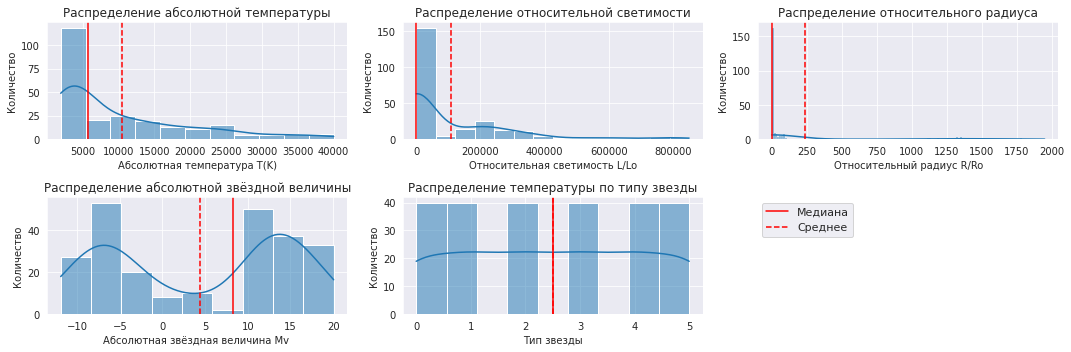

,temperature,luminosity,radius,absolute_magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [10]:
columns = df.select_dtypes(include=np.number).columns.tolist()
display(df[columns].quantile([.015, .985]))
get_overview(df, columns)
df.describe()

In [11]:
df.duplicated().sum()

0

**Вывод**:  
- загруженный набор данных состоит из 240 объектов, содержит 4 числовые и 2 категориальные переменные;  
- пропуски, явные дубликаты и аномальные значения отсутствуют.

## Предобработка и анализ данных

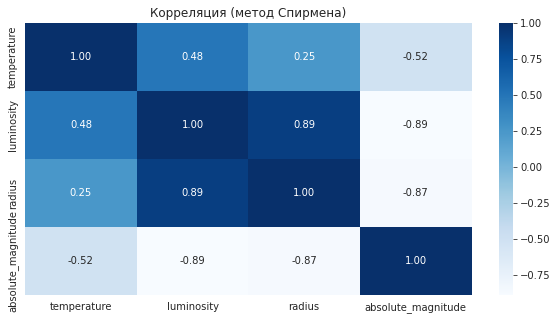

In [12]:
interval_columns = ['temperature', 'luminosity',
                    'radius', 'absolute_magnitude']
plt.figure(figsize=(10, 5))
sns.heatmap(df[interval_columns].corr(method='spearman'), annot=True,
            fmt='.2f', cmap='Blues')
plt.title('Корреляция (метод Спирмена)');

Радиус, светимость и звёздная величина сильно коррелируют друг с другом.

In [13]:
%%time
phik_overview = df.phik_matrix(interval_cols=interval_columns)

CPU times: user 152 ms, sys: 8.72 ms, total: 161 ms
Wall time: 162 ms


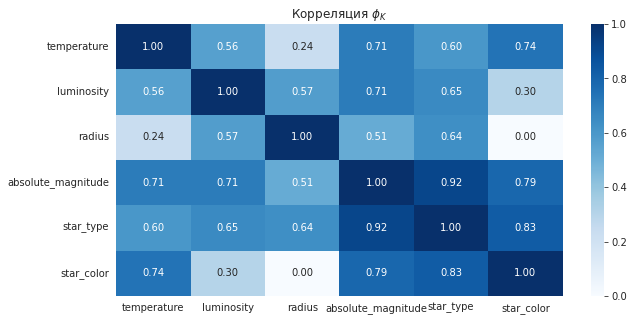

In [14]:
plt.figure(figsize=(10, 5))
sns.heatmap(data=phik_overview, fmt='.2f', cmap='Blues', annot=True)
plt.title('Корреляция $\phi_K$')
plt.show()

Наиболее заметное влияние на целевую переменную оказывают тип и цвет звезды, а также абсолютная звёздная величина.

In [15]:
def get_count_by_group(df, col, col_1):
    total_count = df.shape[0]
    count_by_group = \
        df.pivot_table(index=col, values=col_1, aggfunc='count')
    count_by_group['percentage'] = \
        round(count_by_group[col_1] / total_count * 100, 2)
    count_by_group.columns = ['count', 'percentage']
    return count_by_group

def get_barplot(df, col, order, ax, count_by_group):
    sns.barplot(data=count_by_group, x=count_by_group.index,
                y='count', color='lightslategray', alpha=.2, order=order,
                dodge=False, ax=ax)
    for p, values in zip(ax.patches, count_by_group.loc[order].values):
        count, percent = values
        ax.annotate(f'{count:.0f} ({percent:.2f}%)',
                    (p.get_x(), p.get_height() * 1.005))

def get_median_values(df, col, col_1):
    median_values = df.pivot_table(index=col, values=col_1, aggfunc=['median'])
    median_values.columns = ['median']
    median_values = median_values.sort_values(by='median')
    return median_values

def get_boxplot(data, col, col_1='temperature',
                f_dec=.2, fig_size=(15, 5)):
    count_by_group = get_count_by_group(data, col, col_1)
    groups = count_by_group.index
    median_values = get_median_values(data, col, col_1)
    order = median_values.index

    fig, axs = plt.subplots(2, 1, figsize=fig_size, sharex=True,
                            gridspec_kw={'height_ratios': [3, 1]})
    circles = dict(markerfacecolor='cadetblue',
                   marker='o', markeredgecolor='white')
    pal = sns.color_palette('ch:s=.25,rot=-.25', len(order))
    sns.boxplot(data=data, x=col, y=col_1, hue=col, hue_order=order,
                showmeans=True, order=order, palette=pal, linewidth=0.5,
                medianprops=dict(color='w'), flierprops=circles,
                dodge=False, ax=axs[0])
    for i in range(median_values.shape[0]):
        temp_median = median_values['median'].iloc[i]
        axs[0].text(i-0.15, temp_median+temp_median*0.01,
                 f'{temp_median:{f_dec}f}', color='w', fontweight='bold')

    axs[0].set_ylabel('Температура')
    axs[0].set_title(f'Распределение {title_dict[col][1]}')
    

    get_barplot(data, col, order, axs[1], count_by_group.loc[groups])
    axs[1].set_ylabel('Количество')
    axs[1].set_xlabel(title_dict[col][0])

In [16]:
def add_scatterplot(df, col, ax, col_1):
    ax = ax.twinx()
    sns.scatterplot(data=df,  x=col, y=col_1,
                    hue='star_type', size='star_type', sizes=(10, 100), ax=ax)
    ax.set_ylabel('Температура')
    ax.legend(loc='center right', title='Температура')
    ax.grid(False)


def get_histogram(df, col, bins_num='auto', fig_size=(15, 5),
                  col_1='temperature'):
    fig, axs = plt.subplots(2, 1, figsize=fig_size, sharex=True,
                            gridspec_kw={'height_ratios': [3, 1]})
    get_overview_histogram(df, col, axs[0], bins_num)
    red_circle = dict(
        markerfacecolor='red', marker='o', markeredgecolor='white'
    )
    legend_loc = 'lower right'

    if col != 'temperature':
        add_scatterplot(df, col, axs[0], col_1)

    axs[0].legend(loc=legend_loc, framealpha=0.1)
    ax = axs[1]
    df[col].plot.box(flierprops=red_circle, ax=ax, vert=False)
    ax.set_yticks([])
    ax.set_xlabel(title_dict[col][0])
    plt.tight_layout()

### Абсолютная температура

,count,mean,std,min,25%,50%,75%,max
temperature,240.0,10497.4625,9552.425037,1939.0,3344.25,5776.0,15055.5,40000.0


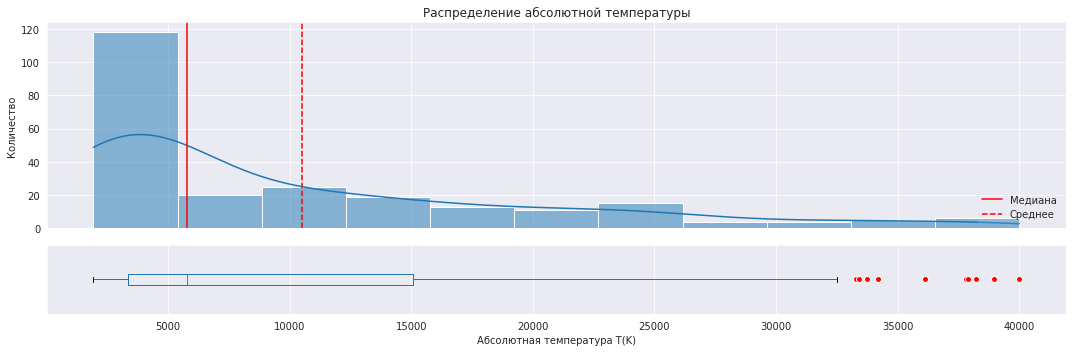

In [17]:
get_histogram(df, 'temperature')
df['temperature'].describe().to_frame().T

Распределение скошено вправо.    
Основная часть объектов обладает температурой, не превышающей 32500 K.

### Дополнительный признак

Используя закон Стефана — Больцмана рассчитаем абсолютную температуру для объектов в наборе данных.

In [18]:
def boltzmann_low(luminosity, radius):
    sun_radius  = 6.9551 * 10**8
    sun_luminosity = 3.828 * 10**26
    return (luminosity * sun_luminosity
            / (4 * math.pi * (radius * sun_radius)**2 * sigma))**0.25

df['temp_stefan_boltzmann'] = df.apply(
    lambda x: boltzmann_low(x['luminosity'], x['radius']), axis=1
)
df

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color,temp_stefan_boltzmann
0,3068,0.002400,0.1700,16.12,0,Red,3098.947669
1,3042,0.000500,0.1542,16.60,0,Red,2198.296189
2,2600,0.000300,0.1020,18.70,0,Red,2378.844864
3,2800,0.000200,0.1600,16.65,0,Red,1716.261263
4,1939,0.000138,0.1030,20.06,0,Red,1949.562004
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue,3878.954039
236,30839,834042.000000,1194.0000,-10.63,5,Blue,5048.713305
237,8829,537493.000000,1423.0000,-10.73,5,White,4143.588756
238,9235,404940.000000,1112.0000,-11.23,5,White,4366.979657


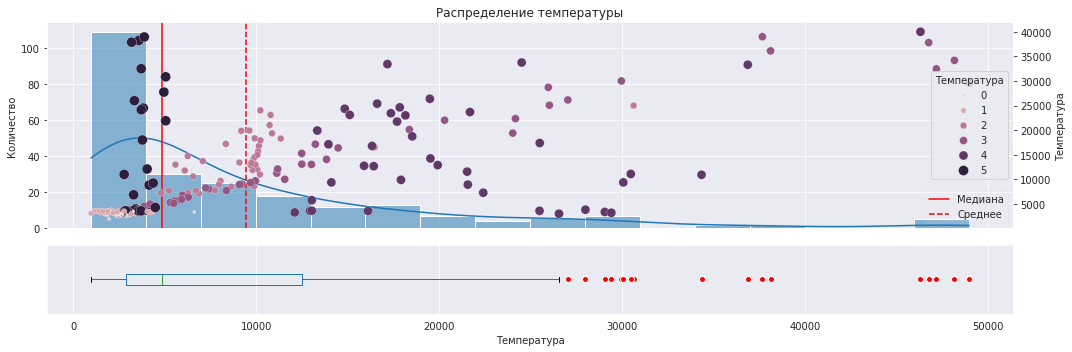

In [19]:
get_histogram(df, 'temp_stefan_boltzmann')

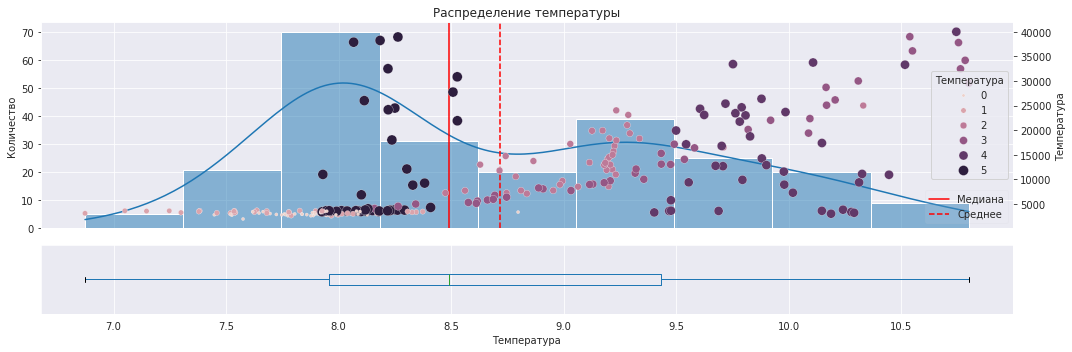

In [20]:
df['temp_stefan_boltzmann'] = np.log(df['temp_stefan_boltzmann'])
get_histogram(df, 'temp_stefan_boltzmann')

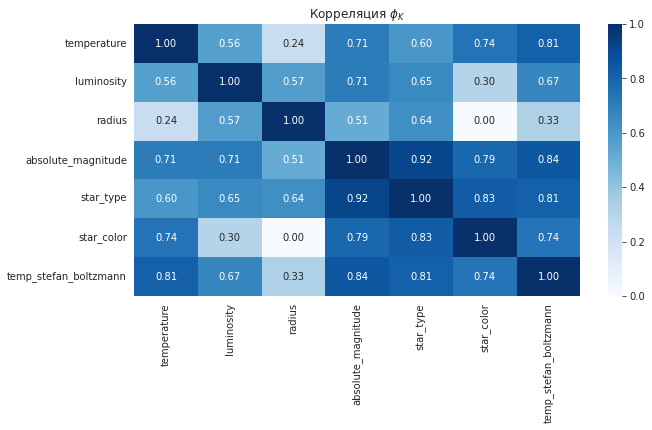

In [21]:
interval_columns.append('temp_stefan_boltzmann')
phik_overview = df.phik_matrix(interval_cols=interval_columns)
plt.figure(figsize=(10, 5))
sns.heatmap(data=phik_overview, fmt='.2f', cmap='Blues', annot=True)
plt.title('Корреляция $\phi_K$')
plt.show()

Целевая переменная наиболее сильно взаимосвязана с новым признаком.

### Относительная светимость

,count,mean,std,min,25%,50%,75%,max
luminosity,240.0,107188.361635,179432.24494,0.00008,0.000865,0.0705,198050.0,849420.0


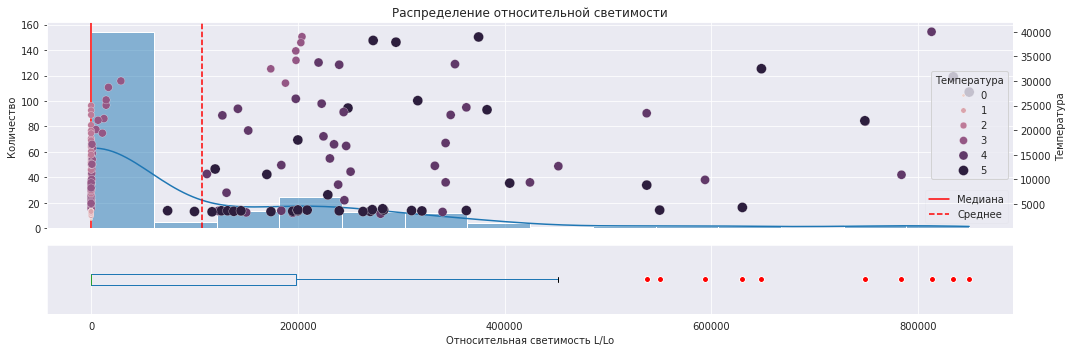

In [22]:
get_histogram(df, 'luminosity')
df['luminosity'].describe().to_frame().T

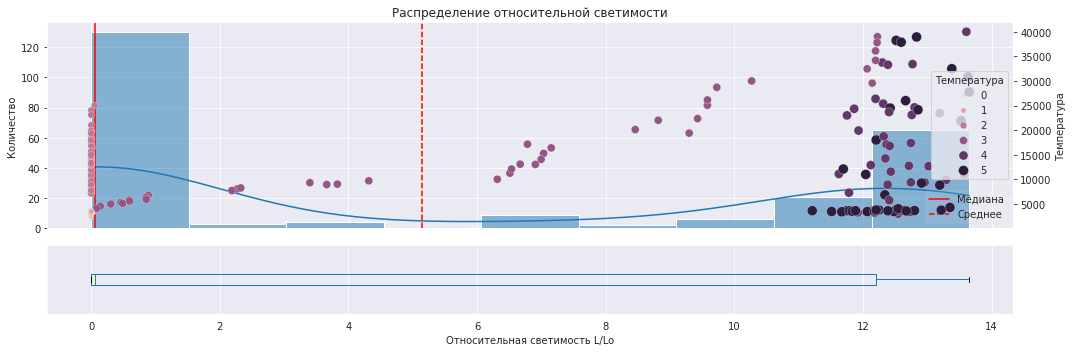

In [23]:
df['luminosity'] = np.log1p(df['luminosity'])
get_histogram(df, 'luminosity')

Относительная светимость сильно коррелирует с абсолютной температурой звёзд главной последиовательности.  
Сильной взаимосвязи между целевым признаком и относительной светимостью остальных объектов не наблюдается.

### Относительный радиус

,count,mean,std,min,25%,50%,75%,max
radius,240.0,237.157781,517.155763,0.0084,0.10275,0.7625,42.75,1948.5


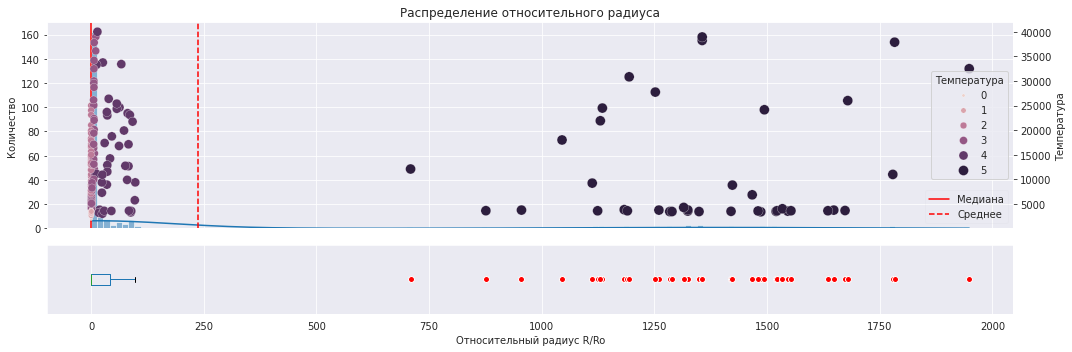

In [24]:
get_histogram(df, 'radius')
df['radius'].describe().to_frame().T

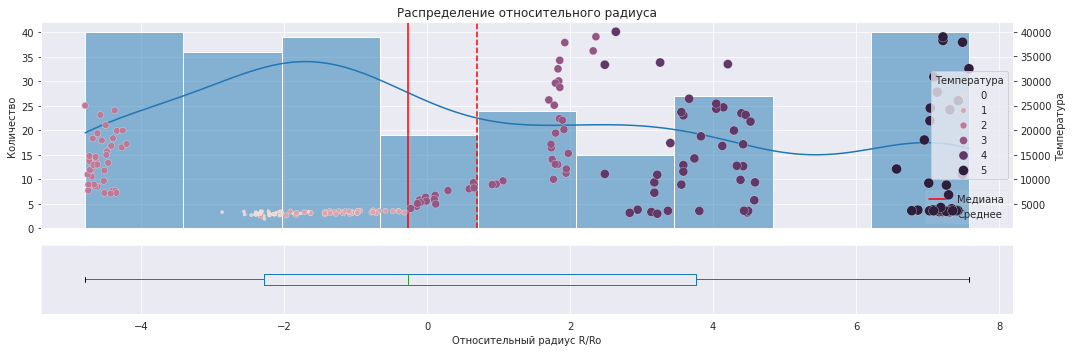

In [25]:
df['radius'] = np.log(df['radius'])
get_histogram(df, 'radius')

Гипергиганты сильно превосходят другие типы звёзд по размеру.  
Корреляция между радиусом и целевым признаком заметна у звёзд главной последовательности и красных карликов.

### Абсолютная звёздная величина

,count,mean,std,min,25%,50%,75%,max
absolute_magnitude,240.0,4.382396,10.532512,-11.92,-6.2325,8.313,13.6975,20.06


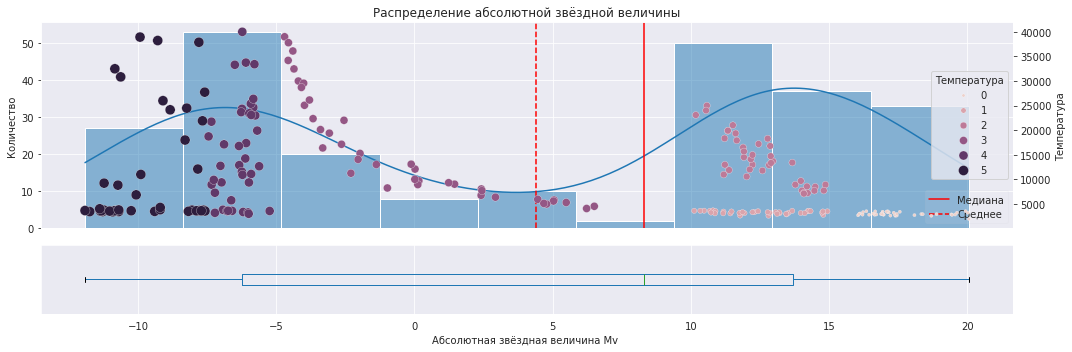

In [26]:
get_histogram(df, 'absolute_magnitude')
df['absolute_magnitude'].describe().to_frame().T

Распределение бимодальное.    
Объекты разделены на кластеры в зависимости от абсолютной звёздной величины и температуры.  
Наибольшее влияние на целевой признак оказывает абсолютная звёздная величина объектов главной последовательности и белых карликов.  
Заметная корреляция между абсолютной звёздной величиной и температурой поверхности гипергигантов и сверхгигантов отсутствует.  

### Тип звезды

[0 1 2 3 4 5]


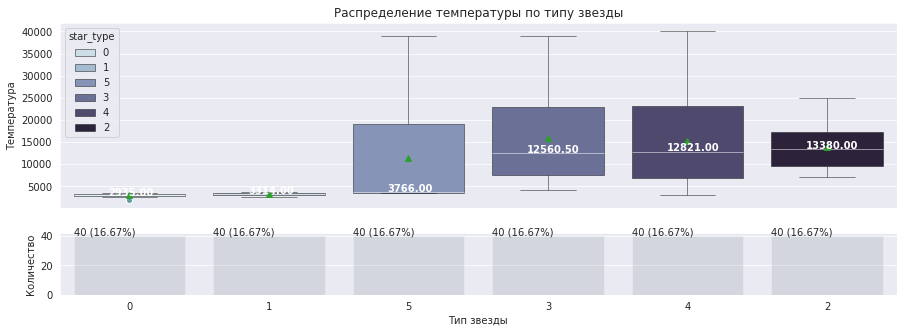

In [27]:
print(df['star_type'].unique())
get_boxplot(df, 'star_type')

Классы переменной сбалансированы.  
Медианные температуры сверхгигантов, звёзд главной последовательности и белых карликов примерно равны, при этом белые карлики отличаются меньшим разбросом значений.

### Звёздный цвет

In [28]:
df['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

В столбце присутствуют дубликаты.

In [29]:
df['star_color'] = df['star_color'].str.strip()
df['star_color'] = df['star_color'].str.lower()
df['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

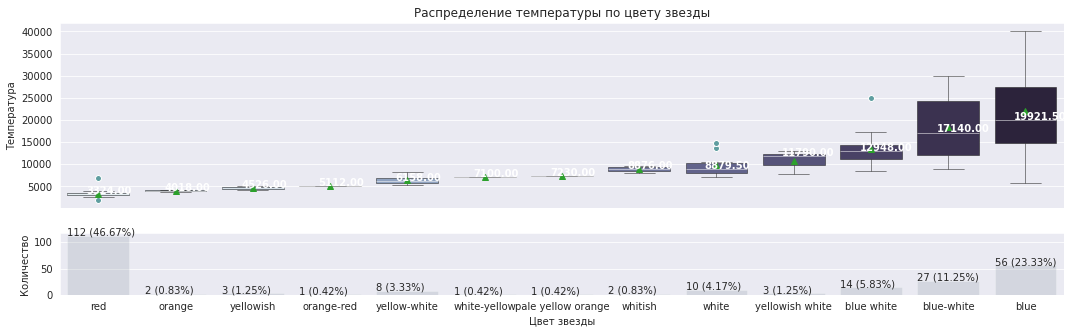

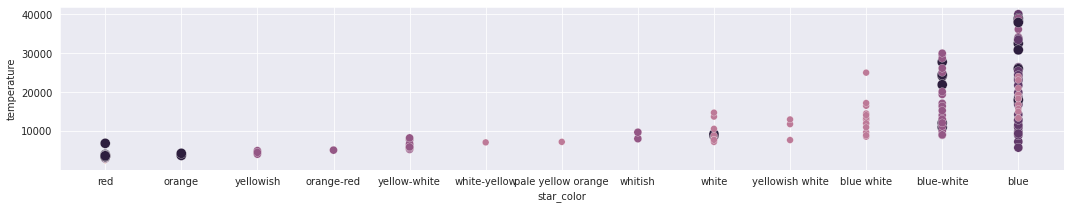

In [30]:
get_boxplot(df, 'star_color', fig_size=(18, 5))
order = get_median_values(df, 'star_color', 'temperature').index
order_dict = {order[i]: i for i in range(len(order))}
plt.figure(figsize=(18, 3))
sns.scatterplot(
    data=df.sort_values(by=['star_color'], key=lambda x: x.map(order_dict)),
    x='star_color', y='temperature',
    hue='star_type', size='star_type', sizes=(10, 100)
)
plt.legend().remove()

In [31]:
df.loc[df['star_color'] == 'blue white', 'star_color'] = 'blue-white'
df.loc[df['star_color'] == 'white-yellow', 'star_color'] = 'yellow-white'

Звёзды красного и оранжевого цвета объединим в общую категорию.  
Для малочисленных групп создадим категорию `other`.

In [32]:
cond = df['star_color'].isin(['red', 'orange'])
df.loc[cond, 'star_color'] = 'red or orange'
other = df['star_color'].value_counts()[lambda x: x < 4].index
df.loc[df['star_color'].isin(other), 'star_color'] = 'other'
df['star_color'].value_counts()

red or orange    114
blue              56
blue-white        41
other             10
white             10
yellow-white       9
Name: star_color, dtype: int64

Основная доля объектов красного, синего и сине-белого цвета.

**Вывод**:  
- проведён анализ данных: признаки рассмотрены с точки зрения целевой переменной;  
- выполнено логорифмирование признаков, содержащих информацию о радиусе и светимости объекта;  
- добавлена переменная, содержащая температуру поверхности звезды (использовался закон Стефана — Больцмана);    
- обработаны неявные добликаты в столбце `star_color`;  
- наибольшее влияние на целевой признак оказывают звёздная величина, цвет и тип звезды.

## Построение базовой нейронной сети

Базовая модель будет состоять из одного скрытого слоя, содержащего 50 нейронов.  
В качестве функции активации используем `LeakyReLu`.

In [33]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, hidden_neurons=[50], n_out_neurons=1,
                 layers_num=1, means=[0], stds=[10], to_drop=[0]):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, hidden_neurons[0])
        self.act1 = nn.LeakyReLU()
        self.dp1 = nn.Dropout(p=to_drop[0])

        layers_num += 1
        self.layers_num = layers_num
        for i in range(2, layers_num):
            exec(f'self.fc{i} = '
                 f'nn.Linear(hidden_neurons[{i-2}], hidden_neurons[{i-1}])')
            exec(f'self.act{i} = nn.LeakyReLU()')
            exec(f'self.dp{i} = nn.Dropout(p=to_drop[{i-1}])')

        self.fcOUT = nn.Linear(hidden_neurons[-1], n_out_neurons)

        for i in range(1, layers_num):
            nn.init.kaiming_normal_(getattr(self, f'fc{i}').weight,
                                    mode='fan_in', nonlinearity='leaky_relu')
            nn.init.normal_(getattr(self, f'fc{i}').bias,
                            mean=means[i-1], std=stds[i-1])

    def forward(self, x):
        x = x.float()

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)

        for i in range(2, self.layers_num):
            x = getattr(self, f'fc{i}')(x)
            x = getattr(self, f'act{i}')(x)
            x = getattr(self, f'dp{i}')(x)

        x = self.fcOUT(x)
        return x

In [34]:
class MyNetRegressor(NeuralNetRegressor):
    def fit(self, X, y=None, **fit_params):
        y = torch.from_numpy(y.values.astype('float32')).float().reshape(-1, 1)
        if not self.warm_start or not self.initialized_:
            self.initialize()

        self.partial_fit(X, y, **fit_params)
        return self

In [35]:
def get_pipe(net):
    ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore',
                                     sparse=False)
    transformer = make_column_transformer(
        (ohe_encoder, [3, 4]), remainder='passthrough'
    )
    pipeline = make_pipeline(transformer, StandardScaler(), net)
    return pipeline

In [36]:
features = df.drop('temperature', axis = 1)
target = df['temperature']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.2, shuffle=True, random_state=SEED
)

In [37]:
%%time
torch.manual_seed(SEED)
def get_model(params):
    model = MyNetRegressor(Net, criterion=nn.MSELoss, module__n_in_neurons=14,
                           optimizer=torch.optim.Adam, **params, verbose=0)
    return model

base_params = {
    'optimizer__lr': .5,
    'callbacks':[EarlyStopping(patience=1000, load_best=True)],
    'batch_size': features_train.shape[0],
    'max_epochs': 10000,
    'iterator_train__shuffle': True
}

base_model = get_model(base_params)
pipe = get_pipe(base_model)

pipe.fit(features_train, target_train)

CPU times: user 14.9 s, sys: 558 ms, total: 15.5 s
Wall time: 15.7 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  [3, 4])])),
                ('standardscaler', StandardScaler()),
                ('mynetregressor',
                 <class '__main__.MyNetRegressor'>[initialized](
  module_=Net(
    (fc1): Linear(in_features=14, out_features=50, bias=True)
    (act1): LeakyReLU(negative_slope=0.01)
    (dp1): Dropout(p=0, inplace=False)
    (fcOUT): Linear(in_features=50, out_features=1, bias=True)
  ),
))])

In [38]:
idx = int(np.max(np.nonzero(pipe[-1].history_[:, 'valid_loss_best'])))

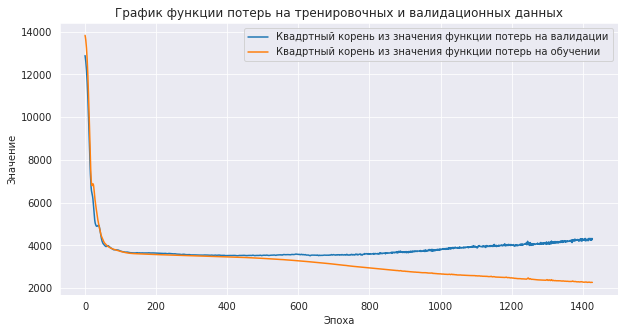

In [39]:
base_result = pipe[-1].history[:, ('train_loss', 'valid_loss')]
base_result = list(map(lambda x: (x[0]**0.5, x[1]**0.5), base_result))
train_valid = pd.DataFrame(base_result, columns=['train_loss', 'valid_loss'])

plt.figure(figsize=(10, 5))
sns.lineplot(data=train_valid, x=train_valid.index, y='valid_loss',
             label='Квадртный корень из значения функции потерь на валидации')
sns.lineplot(data=train_valid, x=train_valid.index, y='train_loss',
             label='Квадртный корень из значения функции потерь на обучении')
plt.title('График функции потерь на тренировочных и валидационных данных')
plt.ylabel('Значение')
plt.xlabel('Эпоха');

In [40]:
%%time
torch.manual_seed(SEED)
base_pipe = get_pipe(pipe[-1])
base_cv = cross_validate(
    base_pipe, features_train, target_train,
    scoring=['neg_root_mean_squared_error', 'r2'],
    cv=KFold(5, random_state=SEED, shuffle=True)
)

CPU times: user 28.2 s, sys: 1.52 s, total: 29.7 s
Wall time: 29.9 s


In [41]:
data_base = {
    'Количество скрытых слоёв': [1],
    'Количество нейронов в скрытом слое': [50],
    'Dropout': 0, 'Learning rate': 0.5, 'Размер батча': ['-'],
    'Квадратный корень из значения функции потерь на валидационной выборке':
    [round(pipe[-1].history[idx]['valid_loss']**0.5, 2)],
    'R2 (кросс-валидация)': [round(base_cv['test_r2'].mean(), 2)],
    'RMSE (кросс-валидация)':
    [round(-base_cv['test_neg_root_mean_squared_error'].mean(), 2)]
}
final_df = pd.DataFrame(data=data_base, index=['Базовая нейронная сеть'])
final_df

,Количество скрытых слоёв,Количество нейронов в скрытом слое,Dropout,Learning rate,Размер батча,Квадратный корень из значения функции потерь на валидационной выборке,R2 (кросс-валидация),RMSE (кросс-валидация)
Базовая нейронная сеть,1,50,0,0.5,-,3515.48,0.74,4475.59


**Вывод**:  
- построена базовая модель, состоящая из одного скрытого слоя с 50 нейронами на нём;  
- значение метрики `RMSE`, полученное на кросс-валидации, равно 4476. 

## Улучшение нейронной сети

In [42]:
def objective(trial, X, y, num_layers=1):
    torch.manual_seed(SEED)
    hidden_neurons = []
    means = []
    stds = []
    to_drop = []
    num = num_layers + 1
    for i in range(1, num):
        hidden_neurons.append(trial.suggest_int(f'hidden_neurons_{i}', 5, 150))
        means.append(trial.suggest_int(f'mean_{i}', -10, 10))
        stds.append(trial.suggest_int(f'std_{i}', 1, 10))
        to_drop.append(trial.suggest_float(f'to_drop_{i}', 0, 0.5))
    params = {
        'module__layers_num': num_layers,
        'module__n_in_neurons': 14,
        'module__hidden_neurons': hidden_neurons,
        'module__means': means,
        'module__stds': stds,
        'optimizer__lr': trial.suggest_float('optimizer__lr', 1e-3, .3),
        'batch_size': trial.suggest_int('batch_size', 10, X.shape[0]),
        'module__to_drop': to_drop,
        'optimizer': torch.optim.Adam,
        'criterion': nn.MSELoss,
        'predict_nonlinearity': None,
        'max_epochs': trial.suggest_int('max_epochs', 50, 300),
        'train_split': None,
        'verbose': 0
        
    }
    model = MyNetRegressor(Net, **params)

    pipe = get_pipe(model)
    result = cross_val_score(
        pipe, X, y, scoring='neg_root_mean_squared_error',
        cv=KFold(5, random_state=SEED, shuffle=True)
    )
    return result.mean()

In [43]:
# func = lambda trial: objective(trial, features_train, target_train)
# sampler = optuna.samplers.TPESampler(seed=SEED)
# study = optuna.create_study(direction='maximize', sampler=sampler)
# study.optimize(func, n_trials=600, show_progress_bar=True)

In [44]:
# best_params = {
#     'module__hidden_neurons': [study.best_params['hidden_neurons_1']],
#     'module__means': [study.best_params['mean_1']],
#     'module__stds': [study.best_params['std_1']],
#     'module__to_drop': [study.best_params['to_drop_1']],
#     'optimizer__lr': study.best_params['optimizer__lr'],
#     'batch_size': study.best_params['batch_size'],
#     'max_epochs': study.best_params['max_epochs'],
#     'train_split': None
# }

best_params = {
    'module__hidden_neurons': [127],
    'module__means': [-5],
    'module__stds': [7],
    'module__to_drop': [0.35001915167603076],
    'optimizer__lr': 0.2567609766766221,
    'batch_size': 107,
    'max_epochs': 165,
    'train_split': None
}

In [45]:
%%time
torch.manual_seed(SEED)
model = get_model(best_params)
pipe = get_pipe(model)
final_cv = cross_validate(
    pipe, features_train, target_train,
    scoring=['neg_root_mean_squared_error', 'r2'],
    cv=KFold(5, random_state=SEED, shuffle=True)
)

CPU times: user 12.6 s, sys: 305 ms, total: 12.9 s
Wall time: 13 s


In [46]:
final_result = [1, best_params['module__hidden_neurons'][0],
                round(best_params['module__to_drop'][0], 2),
                round(best_params['optimizer__lr'], 2),
                round(best_params['batch_size'], 2), '-',
                round(final_cv['test_r2'].mean(), 2),
                round(-final_cv['test_neg_root_mean_squared_error'].mean(), 2)]
final_df.loc['Доработанная нейронная сеть'] = final_result

**Финальное тестирование**

In [47]:
def get_final_metrics(params, X_train=features_train, y_train=target_train,
                      X_test=features_test, y_test=target_test):
    torch.manual_seed(SEED)
    model = get_model(params)
    pipe = get_pipe(model)
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    rmse = mean_squared_error(target_test, predictions)**0.5
    r2 = r2_score(target_test, predictions)
    return [round(r2, 2), round(rmse, 2), predictions]

In [48]:
%%time
base_metrics = get_final_metrics(base_params)
base_predictions = base_metrics.pop()
base_predictions = base_predictions.ravel()
upgraded_metrics = get_final_metrics(best_params)
upgraded_predictions = upgraded_metrics.pop()
upgraded_predictions = upgraded_predictions.ravel()
final_df[['R2 (тестовая выборка)', 'RMSE (тестовая выборка)']] = \
    base_metrics, upgraded_metrics
final_df = final_df.reindex(index=final_df.index[::-1])

CPU times: user 17.8 s, sys: 456 ms, total: 18.2 s
Wall time: 18.3 s


In [49]:
def get_final_graph(preds, title='Базовая нейронная сеть', y_test=target_test):
    plt.figure(figsize=(15, 5))
    sns.barplot(x=y_test.index, y=y_test, color='#99ebff',
                linewidth=0, label='Факт')
    sns.barplot(x=y_test.index, y=preds, width=.45, color='#ffbb33',
                label='Прогноз', linewidth=0)
    plt.ylabel('Температура звезды')
    plt.xlabel('Номер звезды в таблице данных')
    plt.legend(bbox_to_anchor=(0.6015, -0.1), frameon=False,
               fontsize=10, ncol = len(plt.gca().lines))
    plt.title(title)

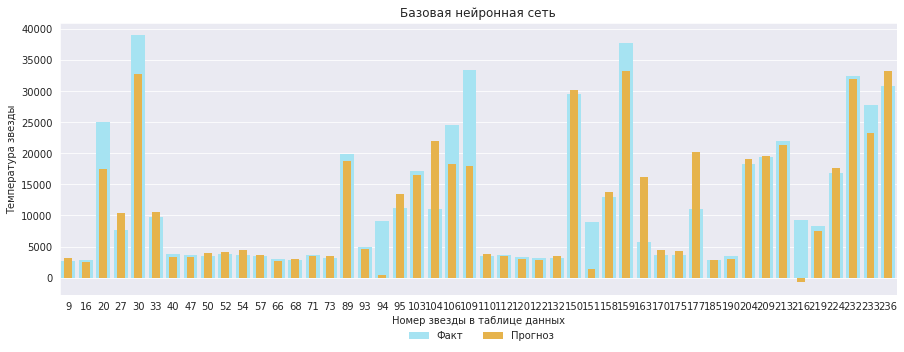

In [50]:
get_final_graph(base_predictions)

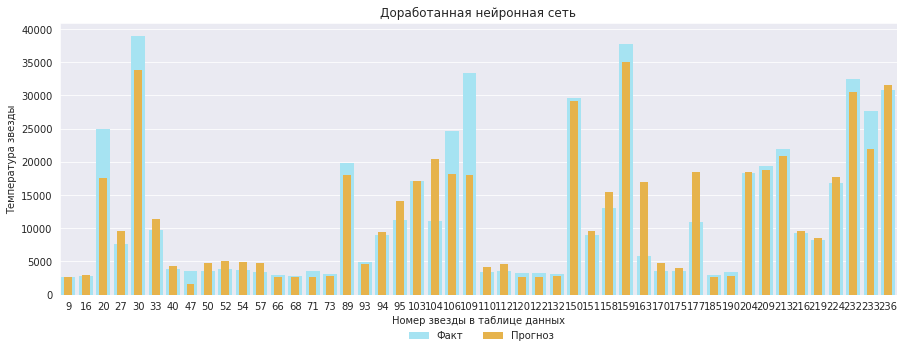

In [51]:
get_final_graph(upgraded_predictions, title='Доработанная нейронная сеть')

In [52]:
final_df

,Количество скрытых слоёв,Количество нейронов в скрытом слое,Dropout,Learning rate,Размер батча,Квадратный корень из значения функции потерь на валидационной выборке,R2 (кросс-валидация),RMSE (кросс-валидация),R2 (тестовая выборка),RMSE (тестовая выборка)
Доработанная нейронная сеть,1,127,0.35,0.26,107,-,0.79,4007.70,0.87,3855.89
Базовая нейронная сеть,1,50,0.00,0.50,-,3515.48,0.74,4475.59,0.82,4539.05


## Выводы

**Описание данных**  
• Относительная светимость L/Lo — светимость звезды относительно Солнца.   
• Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.  
• Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.  
• Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.  
• Тип звезды.  

| **Тип звезды**  | **Номер, соответствующий типу** |
| ------------- | ------------- |
| Коричневый карлик | 0  |
| Красный карлик | 1 |
| Белый карлик	 | 2 |
| Звёзды главной последовательности	 | 3  |
| Сверхгигант | 4 |
| Гипергигант | 5 |  

•	Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.  

**Ход исследования**:  
- проведён предварительный обзор данных: пропуски, аномалии и явные дубликаты отсутствуют;  
- исходя из результатов, полученных посредством использования метода Спирмена и коэффициента Фи, наибольшее влияние на целевой признак оказывают звёздная величина, цвет и тип объекта;  
- добавлен дополнительный признак – абсолютная температура (для расчёта применялся закон Стефана — Больцмана);  
- данные разделены на тренировочную и тестовую выборки в соотношении 4:1;  
- построена базовая нейронная сеть, состоящая из одного скрытого слоя с пятьюдесятью нейронами на нём;  
- базовая модель на кросс-валидации показала `RMSE`, равную 4476;  
- с помощью библиотеки `Optuna` подобраны гиперпараметры нейронной сети;  
- используя доработанную нейронную сеть на кросс-валидации удалось получить метрику `RMSE` равную 4008;  
-	значения метрики `RMSE` полученные на финальном тестировании:  
    - 4539 (базовая нейронная сеть);  
    - 3856 (доработанная нейронная сеть).